In [25]:
from jetutils.definitions import DATADIR, FIGURES, PRETTIER_VARNAME, UNITS, xarray_to_polars, labels_to_mask, compute, infer_direction, get_region
from jetutils.plots import COLORS, TEXTWIDTH_IN, Clusterplot, honeycomb_panel, gather_normal_da_jets_wrapper
from jetutils.data import DataHandler, compute_anomalies_pl, open_da
from jetutils.anyspell import get_persistent_spell_times_from_som, mask_from_spells_pl, subset_around_onset
from jetutils.jet_finding import JetFindingExperiment, haversine_from_dl, get_double_jet_index, find_all_jets, is_polar_gmix
from jetutils.clustering import Experiment, labels_to_centers, timeseries_on_map

import datetime
import numpy as np
import polars as pl
import polars.selectors as cs
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.cm import ScalarMappable
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
exp = JetFindingExperiment(DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/1"))
ds = exp.ds
all_jets_one_df, all_jets_over_time, flags = exp.track_jets()
props_as_df_uncat = exp.props_as_df(False)
props_as_df = exp.props_as_df(True)
all_props_over_time = exp.props_over_time(all_jets_over_time, props_as_df_uncat)
ds = exp.ds
da = exp.ds["s"]
jet_pos_da = exp.jet_position_as_da()
props_as_df = get_double_jet_index(props_as_df, jet_pos_da)
all_jets_one_df = all_jets_one_df.cast({"time": pl.Datetime("ms")})
all_jets_one_df = all_jets_one_df.with_columns((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.Int8).alias("jet ID"))
all_jets_one_df = all_jets_one_df.sort("time", "jet ID", "lon")


diffs = (
    props_as_df[["jet", "time", "mean_lon", "mean_lat"]]
    .group_by("jet")
    .agg(
        pl.col("time"),
        cs.numeric().diff().abs(),
        (
            pl.col("time").diff().cast(pl.Float32())
            / pl.duration(
                seconds=1, time_unit=props_as_df["time"].dtype.time_unit
            ).cast(pl.Float32())
        ).alias("dt"),
        pl.col("mean_lat").alias("actual_lat"),
    )
    .explode(cs.all().exclude("jet"))
    .sort("time", "jet", descending=[False, True])
)
# diffs = diffs.with_columns(com_speed=haversine_from_dl(pl.col("actual_lat"), pl.col("mean_lon"), pl.col("mean_lat")))
diffs = diffs.with_columns(
    com_speed=(
        haversine_from_dl(pl.col("actual_lat"), pl.col("mean_lon"), pl.col("mean_lat"))
        / pl.col("dt")
    )
    .cast(pl.Float32())
    .fill_null(0.0)
)
props_as_df = props_as_df.with_columns(com_speed=diffs["com_speed"])
props_as_df_anoms = compute_anomalies_pl(props_as_df, standardize=True)

In [3]:
def extract_dynamical_seasons(labels: pl.DataFrame, len_spring: int = 20):    
    labels = labels.cast({"time": pl.Datetime("ms")})
    summer_cluster = labels.filter(pl.col("time").dt.month() == 7)["labels"].mode().item()
    seasons = labels.group_by(
        pl.col("time").dt.year().alias("year")
    ).agg(
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().first()).alias("start"),
        pl.col("time").get((pl.col("labels") == summer_cluster).arg_true().last()).alias("end")
    ).with_columns(
        spring=pl.datetime_ranges(pl.col("start") - datetime.timedelta(days=len_spring), pl.col("start"), "6h"),
        summer=pl.datetime_ranges(pl.col("start"), pl.col("end"), "6h"),
        autumn=pl.datetime_ranges(pl.col("end"), pl.col("end") + datetime.timedelta(days=len_spring), "6h"),
    ).drop("year", "start", "end")
    return [seasons[season].explode().sort() for season in seasons.columns]

In [4]:
dh = DataHandler(f"{DATADIR}/ERA5/plev/high_wind/6H/results/3")
exp_wind = Experiment(dh)
centers_kmeans, labels_kmeans = exp_wind.do_kmeans(7, 200)
spring, summer, autumn = extract_dynamical_seasons(xarray_to_polars(labels_kmeans), 20)
summer_daily = summer.filter(summer.dt.hour() == 0)
da_summer = dh.da.sel(time=summer.to_numpy())
dh_summer = DataHandler.from_basepath_and_da(exp_wind.path.parent, da_summer, save_da=True)
exp_summer = Experiment(dh_summer)
nx, ny, n_pca = 4, 4, 200
net, centers, labels = exp_summer.som_cluster(
    nx,
    ny,
    n_pca,
    sigma=1.5,
    sigmaN=1e-5,
    train_kwargs=dict(num_epochs=20),
    init="pca",
)
populations = net.compute_populations()
coords = net.neighborhoods.coordinates

ds_center_path = exp_summer.path.joinpath(f"uvs_som_{nx}_{ny}_{n_pca}_pbc_center.nc")
if not ds_center_path.is_file():
    ds = exp.ds
    ds_center_summer = labels_to_centers(labels, ds)
    ds_center_summer.to_netcdf(ds_center_path)
else:
    ds_center_summer = xr.open_dataset(ds_center_path)
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": exp_summer.da.time, "cluster": np.arange(net.n_nodes)})

all_jets_center_summer = find_all_jets(ds_center_summer.drop_vars(["ratio", "label"]), base_s_thresh=22, alignment_thresh=0.5)
all_jets_center_summer = is_polar_gmix(all_jets_center_summer, ("lon", "lat", "lev"), n_components=2, n_init=100, mode="year")

100%|██████████| 16/16 [00:00<00:00, 251.31it/s]


In [35]:
from sklearn.metrics import pairwise_distances
dists = pairwise_distances(net.weights)
spells = get_persistent_spell_times_from_som(labels, dists, 0, 24, nt_before=20, nojune=False, daily=True)
spells = spells.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")})

labels_daily = labels.sel(time=labels.time.dt.hour == 0)
mask_daily = labels_to_mask(labels_daily)
jets_daily = all_jets_one_df.filter(pl.col("time").is_in(summer_daily))

spells_per_cluster = spells.filter(pl.col("relative_index") == 0).group_by("value").len()
spells_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(spells_per_cluster, how="left", on="value").fill_null(0)
numbering = [f"{numb + 1}, {spells_per_cluster[int(numb), 'len']}" for numb in range(net.n_nodes)]

props_as_df_anoms = compute_anomalies_pl(props_as_df, ("jet", ), 31, standardize=True)
props_masked = mask_from_spells_pl(spells, props_as_df_anoms, time_before=datetime.timedelta(days=5))
props_masked_ = props_masked.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet")).mean().rename({"value": "cluster"})
indexer = pl.Series("cluster", np.arange(net.n_nodes)).to_frame().join(props_masked[:, ["jet", "relative_index"]].unique(("jet", "relative_index")), how="cross").sort("cluster", "jet", "relative_index")
props_masked_ = indexer.join(props_masked_, how="left", on=["cluster", "jet", "relative_index"])

(<Figure size 500x400 with 2 Axes>, <Axes: >)

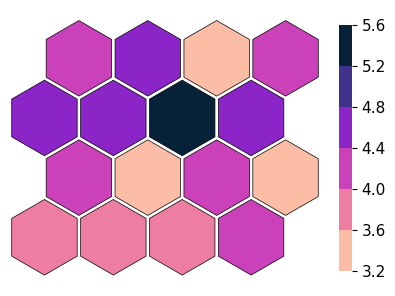

In [8]:
## max len
max_len_per_cluster = spells.group_by(["value", "spell"]).len().group_by("value").agg(pl.col("len").max() / 4)
max_len_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(max_len_per_cluster, how="left", on="value")
cmap = colormaps.bubblegum_r
net.plot_on_map(max_len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.8})

(<Figure size 500x400 with 2 Axes>, <Axes: >)

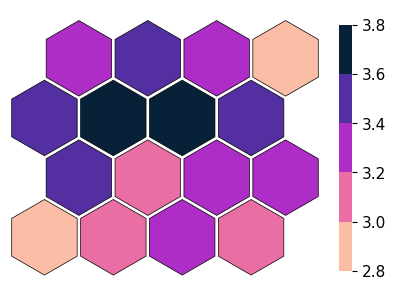

In [9]:
## mean len
len_per_cluster = spells.group_by("value").len()
len_per_cluster = pl.Series("value", np.arange(net.n_nodes)).to_frame().join(len_per_cluster, how="left", on="value").fill_null(0)
len_per_cluster = len_per_cluster.with_columns(pl.col("len") / spells_per_cluster["len"] / 4)
cmap = colormaps.bubblegum_r
net.plot_on_map(len_per_cluster["len"].to_numpy(), cmap=cmap, linewidths=0.5, discretify=True, cbar_kwargs={"shrink": 0.8})

In [36]:
spells_any = get_persistent_spell_times_from_som(
    labels, dists, 0, 1, nt_before=0, nojune=False, daily=False
)
spells_any = spells_any.cast(
    {"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}
)

props_masked_short = mask_from_spells_pl(spells_any.filter(pl.col("len") < 12), props_as_df_anoms)
props_masked_short_ = props_masked_short.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet")).mean().rename({"value": "cluster"})
indexer = pl.Series("cluster", np.arange(net.n_nodes)).to_frame().join(props_masked_short[:, ["jet", "relative_index"]].unique(("jet", "relative_index")), how="cross").sort("cluster", "jet", "relative_index")
props_masked_short_ = indexer.join(props_masked_short_, how="left", on=["cluster", "jet", "relative_index"])
mean_props_short = props_masked_short_.group_by(pl.col(["cluster", "jet"])).mean().sort("cluster", "jet")

props_masked_long = mask_from_spells_pl(spells_any.filter(pl.col("len") > 24), props_as_df_anoms)
props_masked_long_ = props_masked_long.group_by(pl.col("value"), pl.col("relative_index"), pl.col("jet")).mean().rename({"value": "cluster"})
indexer = pl.Series("cluster", np.arange(net.n_nodes)).to_frame().join(props_masked_long[:, ["jet", "relative_index"]].unique(("jet", "relative_index")), how="cross").sort("cluster", "jet", "relative_index")
props_masked_long_ = indexer.join(props_masked_long_, how="left", on=["cluster", "jet", "relative_index"])
mean_props_long = props_masked_long_.group_by(pl.col(["cluster", "jet"])).mean().sort("cluster", "jet")

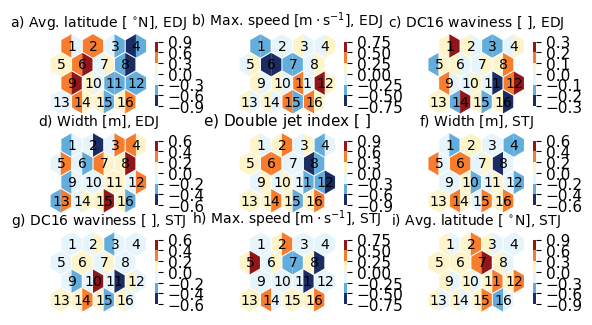

In [43]:
from string import ascii_lowercase

data_vars_and_jets = [
    ("mean_lat", "EDJ"),
    ("s_star", "EDJ"),
    ("wavinessDC16", "EDJ"),
    ("width", "EDJ"),
    ("double_jet_index", "STJ"),
    ("width", "STJ"),
    ("wavinessDC16", "STJ"),
    ("s_star", "STJ"),
    ("mean_lat", "STJ"),
]

fig, axes = plt.subplots(3, 3, figsize=(TEXTWIDTH_IN, 2.9), gridspec_kw=dict(wspace=0.15, hspace=0.15, bottom=0.00, top=0.98), sharex="all", subplot_kw=dict(aspect="equal"))
axes1 = axes.flatten()
for letter, (varname, jet), (j, ax) in zip(ascii_lowercase, data_vars_and_jets, enumerate(axes1)):
    to_plot_1 = mean_props_short.filter(pl.col("jet") == jet)[varname].to_numpy()
    to_plot_2 = mean_props_long.filter(pl.col("jet") == jet)[varname].to_numpy()
    if varname == "double_jet_index":
        cmap = colormaps.BlueWhiteOrangeRed
        ax.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}]", pad=2)
    else:
        cmap = colormaps.BlueWhiteOrangeRed
        ax.set_title(f"{letter}) {PRETTIER_VARNAME[varname]} [{UNITS.get(varname, '')}], {jet}", pad=2, fontsize=10)
    big_feature = np.concatenate([to_plot_1, to_plot_2])
    symmetric = infer_direction(np.nan_to_num(big_feature)) == 0
    levels = MaxNLocator(6 if symmetric else 4, symmetric=symmetric).tick_values(np.nanmin(big_feature), np.nanmax(big_feature))
    norm = BoundaryNorm(levels, cmap.N)
    cmap.set_bad(color="powderblue")
    fig, ax = net.plot_on_map(
        to_plot_1,
        to_plot_2,
        smooth_sigma=0,
        show=False,
        fig=fig,
        ax=ax,
        draw_cbar=True,
        cmap=cmap,
        norm=norm,
        linewidths=0,
        cbar_kwargs=dict(shrink=0.75),
        numbering=True,
    )
fig.savefig("/storage/homefs/hb22g102/persistent-extremes-era5/Figures/Poster_EGU25/jet_props_SOM_short_long")

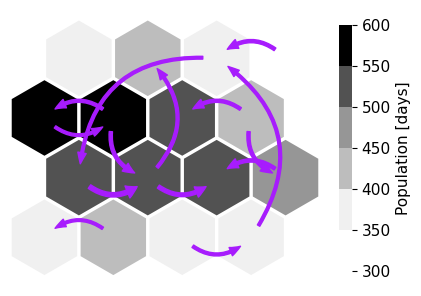

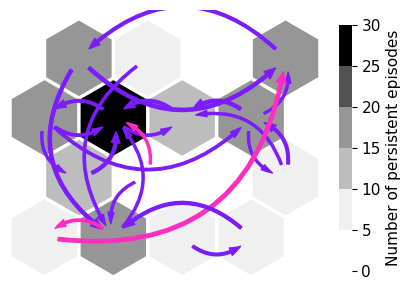

In [ ]:
import matplotlib.patches as patches
import polars.selectors as cs
from itertools import product

# What happens before?
spells = get_persistent_spell_times_from_som(
    labels, dists, 0, 24, nt_before=1, nojune=False, daily=False
)
spells = spells.cast({"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")})
spells_any = get_persistent_spell_times_from_som(
    labels, dists, 0, 1, nt_before=1, nojune=False, daily=False
)
spells_any = spells_any.cast(
    {"time": pl.Datetime("ms"), "relative_time": pl.Duration("ms")}
)
longest_spell = (
    spells.group_by("value")
    .agg(pl.col("time").filter(pl.col("len") == pl.col("len").max()))
    .explode("time")
    .join(spells, on=["value", "time"])
    .sort("value", "time")
)

labels_masked = spells.join(
    xarray_to_polars(labels).cast({"time": pl.Datetime("ms")}), on="time"
)
labels_any_masked = spells_any.join(
    xarray_to_polars(labels).cast({"time": pl.Datetime("ms")}), on="time"
)
labels_longest_masked = longest_spell.join(
    xarray_to_polars(labels).cast({"time": pl.Datetime("ms")}), on="time"
)
rel_ind = -1
index = pl.int_range(0, 16, eager=True).rename("labels").to_frame()
transitions_any = index.clone()
transitions_spell = index.clone()
transitions_longest = index.clone()

for i in range(16):
    a = labels_any_masked.filter(
        pl.col("value") == i, pl.col("relative_index") == rel_ind
    )["labels"].value_counts(sort=True)
    transitions_any = transitions_any.join(
        a.rename({"count": f"trans to {i}"}), on="labels", how="left"
    )
    a = labels_masked.filter(pl.col("value") == i, pl.col("relative_index") == rel_ind)[
        "labels"
    ].value_counts(sort=True)
    transitions_spell = transitions_spell.join(
        a.rename({"count": f"trans to {i}"}), on="labels", how="left"
    )
    a = labels_longest_masked.filter(
        pl.col("value") == i, pl.col("relative_index") == rel_ind
    )["labels"].value_counts(sort=True)
    transitions_longest = transitions_longest.join(
        a.rename({"count": f"trans to {i}"}), on="labels", how="left"
    )

## spells per cluster

spells_per_cluster = (
    spells.filter(pl.col("relative_index") == 0).group_by("value").len()
)
spells_per_cluster = (
    pl.Series("value", np.arange(net.n_nodes))
    .to_frame()
    .join(spells_per_cluster, how="left", on="value")
    .fill_null(0)
)
cmap = colormaps.greys
transitions_any_ = transitions_any.fill_null(0).with_columns(
    cs.contains("trans") / pl.sum_horizontal(cs.contains("trans"))
)
fig, ax = net.plot_on_map(
    populations / 4,
    cmap=cmap,
    discretify=True,
    cbar_kwargs={"shrink": 0.8, "label": "Population [days]"},
)
thresh = 0.2
arrowcount = 0
for i, j in product(range(16), range(16)):
    if i == j:
        continue
    strength = transitions_any_.fill_null(0)[i, f"trans to {j}"]
    if strength < thresh:
        continue
    arrowcount += 1
    tail_width = ((strength - thresh + 1) * 1.2) ** 3.6
    head_width = tail_width * 3
    style = f"Simple, tail_width={tail_width:.3f}, head_width={head_width:.3f}, head_length=8"
    kw = dict(
        arrowstyle=style,
        connectionstyle="arc3,rad=.5",
        color=COLORS[0],
        shrinkA=10,
        shrinkB=10,
    )
    ax.add_patch(patches.FancyArrowPatch(coords[i], coords[j], **kw))
## spells per cluster
fig.savefig(f"{FIGURES}/Poster_EGU25/transi_any.png")

spells_per_cluster = (
    spells.filter(pl.col("relative_index") == 0).group_by("value").len()
)
spells_per_cluster = (
    pl.Series("value", np.arange(net.n_nodes))
    .to_frame()
    .join(spells_per_cluster, how="left", on="value")
    .fill_null(0)
)
cmap = colormaps.greys
transitions_spell_ = transitions_spell.fill_null(0).with_columns(
    cs.contains("trans") / pl.sum_horizontal(cs.contains("trans"))
)
fig, ax = net.plot_on_map(
    spells_per_cluster["len"].to_numpy(),
    cmap=cmap,
    discretify=True,
    cbar_kwargs={"shrink": 0.8, "label": "Number of persistent episodes"},
)
thresh = 0.25
arrowcount = 0
for i, j in product(range(16), range(16)):
    if i == j:
        continue
    strength = transitions_spell_.fill_null(0)[i, f"trans to {j}"]
    if strength < thresh:
        continue
    is_longest = transitions_longest[i, f"trans to {j}"] is not None
    arrowcount += 1
    tail_width = ((strength - thresh + 1) * 1.2) ** 2.0
    head_width = tail_width * 3
    color = COLORS[2] if is_longest else COLORS[1]
    style = f"Simple, tail_width={tail_width:.3f}, head_width={head_width:.3f}, head_length=8"
    kw = dict(
        arrowstyle=style,
        connectionstyle="arc3,rad=.5",
        color=color,
        shrinkA=10,
        shrinkB=10,
    )
    ax.add_patch(patches.FancyArrowPatch(coords[i], coords[j], **kw))
fig.savefig(f"{FIGURES}/Poster_EGU25/transi_hs.png")

In [77]:
transitions_spell / transitions_any

shape: (16, 17)
┌────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ labels ┆ trans to 0 ┆ trans to 1 ┆ trans to  ┆ … ┆ trans to  ┆ trans to  ┆ trans to  ┆ trans to  │
│ ---    ┆ ---        ┆ ---        ┆ 2         ┆   ┆ 12        ┆ 13        ┆ 14        ┆ 15        │
│ f64    ┆ f64        ┆ f64        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│        ┆            ┆            ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ NaN    ┆ null       ┆ null       ┆ null      ┆ … ┆ null      ┆ 0.043478  ┆ null      ┆ null      │
│ 1.0    ┆ 0.142857   ┆ null       ┆ null      ┆ … ┆ null      ┆ 0.125     ┆ null      ┆ null      │
│ 1.0    ┆ 0.071429   ┆ 0.05       ┆ null      ┆ … ┆ null      ┆ null      ┆ 0.086957  ┆ 0.047619  │
│ 1.0    ┆ 0.2        ┆ null       ┆ 0.051282  ┆ … ┆ 0.0625    ┆ null      ┆ null      ┆ 0.074074  │
│ 1.0    ┆ null       ┆ null       ┆ null      ┆ … ┆ null      ┆ 0.25      ┆ null      ┆ null      │
│ …      ┆ …          ┆ …          ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 1.0    ┆ null       ┆ null       ┆ null      ┆ … ┆ null      ┆ null      ┆ null      ┆ null      │
│ 1.0    ┆ 0.08       ┆ null       ┆ null      ┆ … ┆ null      ┆ 0.058824  ┆ null      ┆ 0.037037  │
│ 1.0    ┆ 0.066667   ┆ null       ┆ null      ┆ … ┆ 0.108108  ┆ null      ┆ 0.052632  ┆ 0.05      │
│ 1.0    ┆ null       ┆ null       ┆ null      ┆ … ┆ 0.04      ┆ 0.037037  ┆ null      ┆ 0.046512  │
│ 1.0    ┆ 0.4        ┆ null       ┆ 0.025     ┆ … ┆ 0.03125   ┆ 0.121212  ┆ null      ┆ null      │
└────────┴────────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [48]:
import polars.selectors as cs
transitions_any.with_columns(cs.contains("trans") / pl.sum_horizontal(cs.contains("trans")))

shape: (16, 17)
┌────────┬────────────┬────────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ labels ┆ trans to 0 ┆ trans to 1 ┆ trans to  ┆ … ┆ trans to  ┆ trans to  ┆ trans to  ┆ trans to  │
│ ---    ┆ ---        ┆ ---        ┆ 2         ┆   ┆ 12        ┆ 13        ┆ 14        ┆ 15        │
│ i64    ┆ f64        ┆ f64        ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
│        ┆            ┆            ┆ f64       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
╞════════╪════════════╪════════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 0      ┆ null       ┆ 0.078313   ┆ 0.03012   ┆ … ┆ 0.186747  ┆ 0.138554  ┆ 0.018072  ┆ 0.048193  │
│ 1      ┆ 0.0875     ┆ null       ┆ 0.0625    ┆ … ┆ 0.025     ┆ 0.133333  ┆ 0.041667  ┆ 0.033333  │
│ 2      ┆ 0.061135   ┆ 0.087336   ┆ null      ┆ … ┆ 0.0131    ┆ 0.008734  ┆ 0.100437  ┆ 0.091703  │
│ 3      ┆ 0.159236   ┆ null       ┆ 0.248408  ┆ … ┆ 0.101911  ┆ 0.006369  ┆ 0.057325  ┆ 0.171975  │
│ 4      ┆ 0.006667   ┆ 0.02       ┆ 0.056667  ┆ … ┆ 0.023333  ┆ 0.013333  ┆ null      ┆ 0.04      │
│ …      ┆ …          ┆ …          ┆ …         ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 11     ┆ 0.006873   ┆ 0.003436   ┆ 0.020619  ┆ … ┆ 0.044674  ┆ null      ┆ 0.041237  ┆ 0.010309  │
│ 12     ┆ 0.132275   ┆ 0.005291   ┆ 0.015873  ┆ … ┆ null      ┆ 0.089947  ┆ 0.174603  ┆ 0.142857  │
│ 13     ┆ 0.163934   ┆ 0.081967   ┆ null      ┆ … ┆ 0.202186  ┆ null      ┆ 0.103825  ┆ 0.10929   │
│ 14     ┆ 0.031746   ┆ 0.185185   ┆ 0.047619  ┆ … ┆ 0.132275  ┆ 0.142857  ┆ null      ┆ 0.227513  │
│ 15     ┆ 0.026042   ┆ 0.015625   ┆ 0.208333  ┆ … ┆ 0.166667  ┆ 0.171875  ┆ 0.145833  ┆ null      │
└────────┴────────────┴────────────┴───────────┴───┴───────────┴───────────┴───────────┴───────────┘

# Data and such

In [ ]:
da_tp = open_da(
    "ERA5", "surf", "tp", "dailysum", "all", None, *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_tp = da_tp.sel(time=summer_daily.to_numpy())
da_tp = compute(da_tp, progress_flag=True)

da_T = open_da(
    "ERA5", "surf", "t2m", "dailymean", "all", None, *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_T = da_T.sel(time=summer_daily.to_numpy())
da_T = compute(da_T, progress_flag=True)

da_apvs = open_da(
    "ERA5", "thetalev", "apvs", "dailyany", "all", None, *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_apvs = da_apvs.sel(time=summer_daily.to_numpy())
da_apvs = compute(da_apvs, progress_flag=True)

da_cpvs = open_da(
    "ERA5", "thetalev", "cpvs", "dailyany", "all", None, *get_region(ds), "all", 'dayofyear', {'dayofyear': ('win', 15)}, None,
)
da_cpvs = da_cpvs.sel(time=summer_daily.to_numpy())
da_cpvs = compute(da_cpvs, progress_flag=True)


# natural coordinate composites

In [91]:
def symmetrize_p(pvals: xr.DataArray | np.ndarray, direction: int, q: float) -> np.ndarray:
    if direction == 0:
        return np.amin([pvals * 2, (1 - pvals) * 2], axis=0) < q
    if direction == 1:
        return np.asarray(pvals) > 1 - q
    return np.asarray(pvals) < q


def plot_all_relative_composites(jets, times, variable_dict, n_bootstraps: int = 50):
    figs = []
    for varname, props in variable_dict.items():
        if len(props) == 3:
            da, nlevels, cmap = props
            clim = None
        else:
            da, clim, nlevels, cmap = props
        hatch = "xxx" if varname == "tp" else "xx"
        
        jets_during_spells_with_interp_norm_ds = gather_normal_da_jets_wrapper(jets, times, da, n_bootstraps=n_bootstraps, clim=clim)
        try:
            to_plot = jets_during_spells_with_interp_norm_ds[da.name + "_interp"]
            pvals = jets_during_spells_with_interp_norm_ds["pvals"]
        except KeyError:
            to_plot = jets_during_spells_with_interp_norm_ds
            
        direction = infer_direction(to_plot)
        symmetric = direction == 0

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        levels = MaxNLocator(nlevels, symmetric=symmetric).tick_values(to_plot.quantile(0.01), to_plot.quantile(0.99))
        norm = BoundaryNorm(levels, cmap.N)
        
        axes[0].pcolormesh(to_plot.norm_index, to_plot.n, to_plot[0].T, norm=norm, cmap=cmap)
        filter_ = symmetrize_p(pvals[0].T, direction, 0.05)
        axes[0].pcolor(pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.)
        
        axes[1].pcolormesh(to_plot.norm_index, to_plot.n, to_plot[1].T, norm=norm, cmap=cmap)
        filter_ = symmetrize_p(pvals[1].T, direction, 0.05)
        axes[1].pcolor(pvals.norm_index, pvals.n, pvals[0].T.where(filter_), hatch=hatch, alpha=0.)

        fig.colorbar(ScalarMappable(norm, cmap), ax=axes, spacing="proportional")
        figs.append(fig)
    return figs

# clim_T = xr.open_dataarray(exp.path.joinpath("t2m_relative_clim.nc"))
# clim_tp = xr.open_dataarray(exp.path.joinpath("tp_relative_clim.nc"))
# clim_apvs = xr.open_dataarray(exp.path.joinpath("apvs_relative_clim.nc"))
# clim_cpvs = xr.open_dataarray(exp.path.joinpath("cpvs_relative_clim.nc"))
# clim_sst = xr.open_dataarray(exp.path.joinpath("sst_relative_clim.nc"))

# variable_dict = {
#     "t2m": [da_T, clim_T, 8, colormaps.BlWhRe],
#     "tp": [da_tp, clim_tp, 15, colormaps.precip4_diff_19lev],
#     "APVS": [da_apvs, clim_apvs, 7, colormaps.curl],
#     "CPVS": [da_cpvs, clim_cpvs, 7, colormaps.curl],
#     "sst": [da_sst, clim_sst, 7, colormaps.BlWhRe]
# }
variable_dict = {
    "t2m": [da_T, 8, colormaps.BlWhRe],
    "tp": [da_tp * 1000, 13, colormaps.precip4_diff_19lev],
    "APVS": [da_apvs, 7, colormaps.curl],
    "CPVS": [da_cpvs, 7, colormaps.curl],
}

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

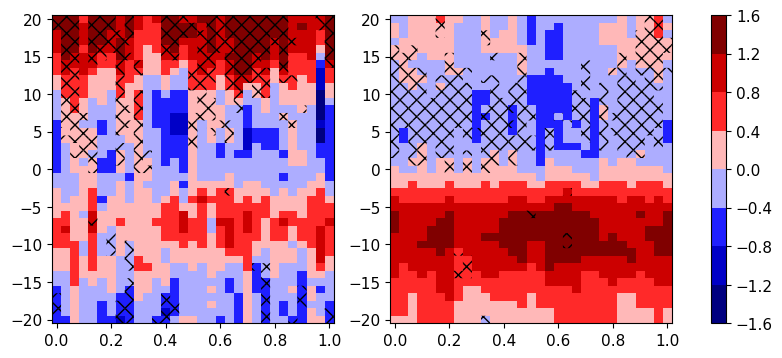

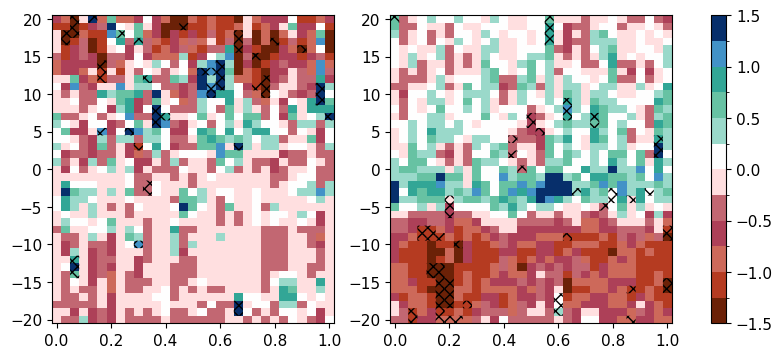

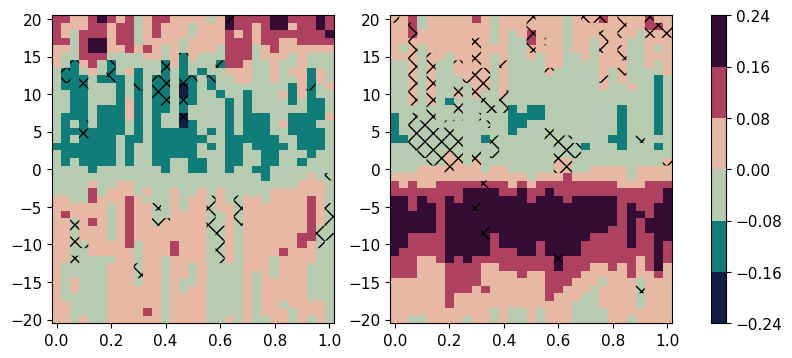

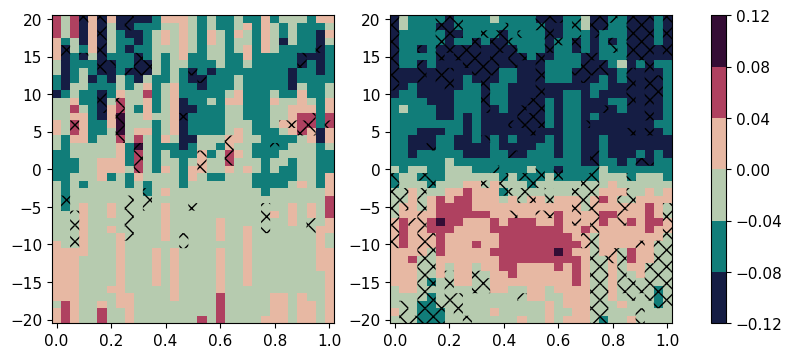

In [92]:
spells_som = spells.filter(pl.col("value") == 5)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

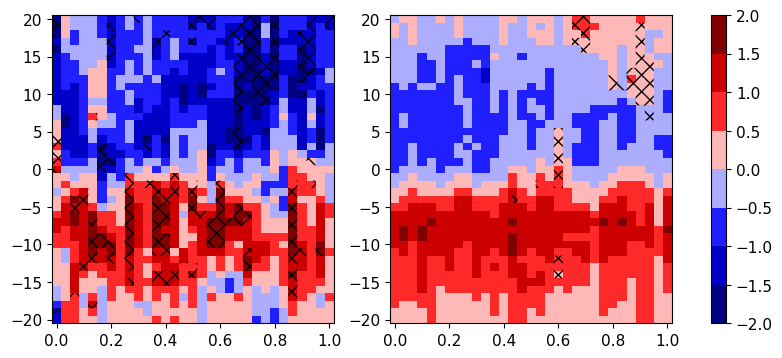

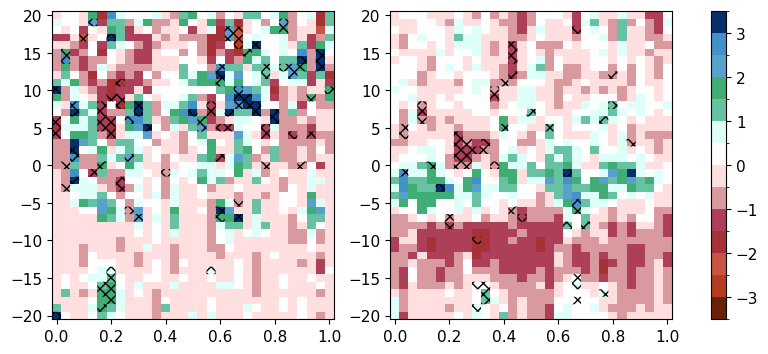

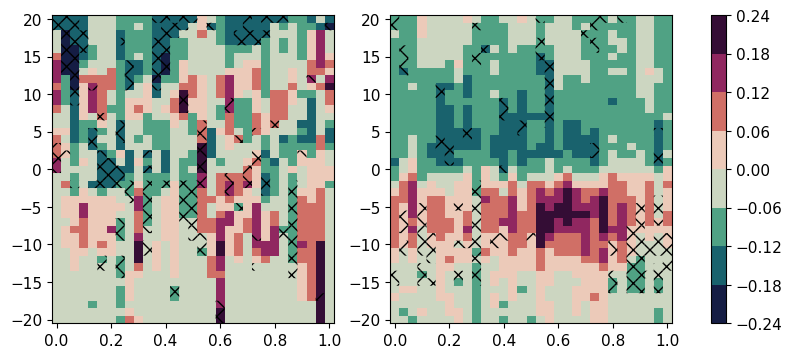

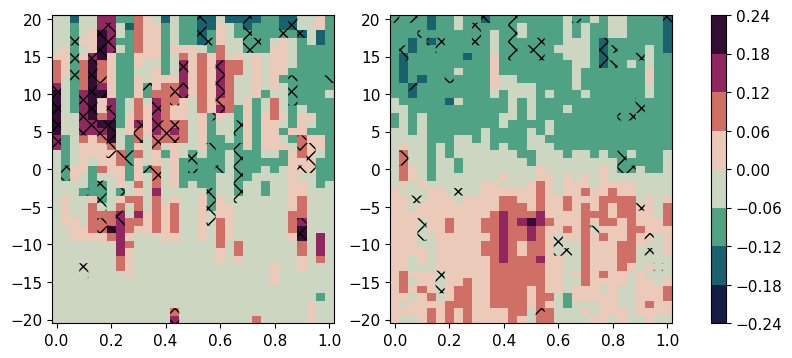

In [93]:
spells_som = spells.filter(pl.col("value") == 6)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

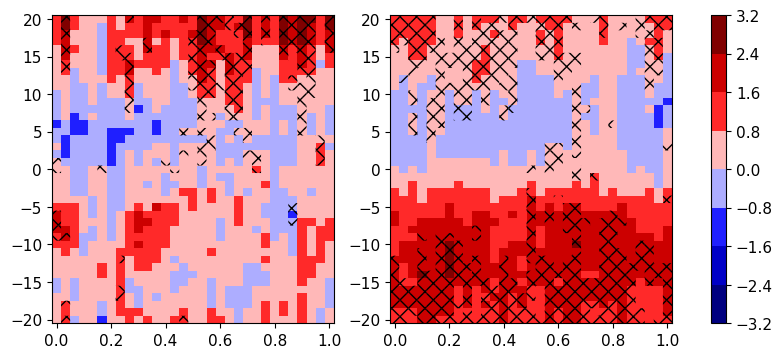

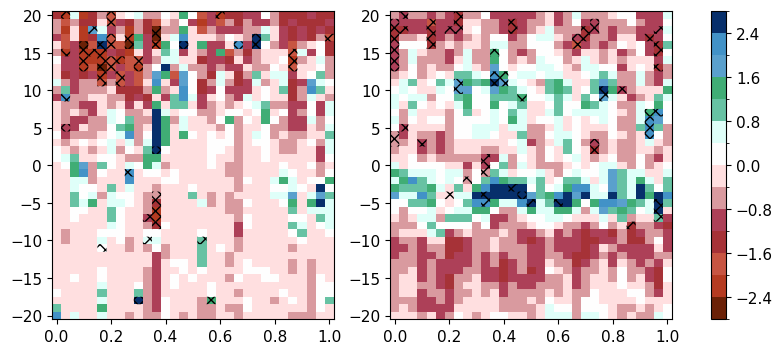

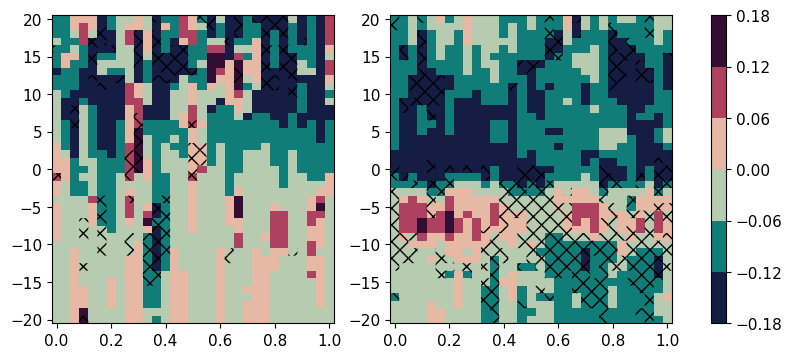

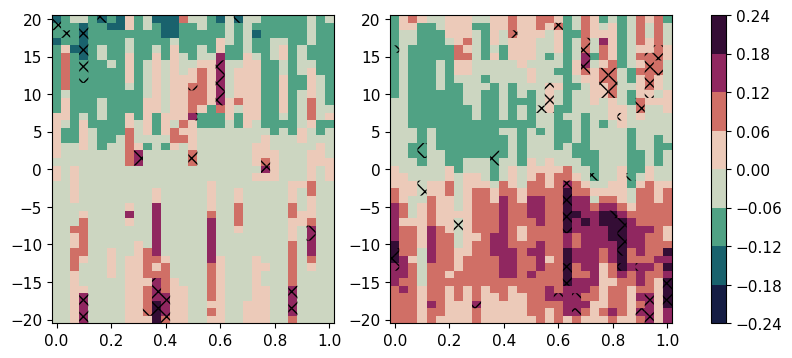

In [94]:
spells_som = spells.filter(pl.col("value") == 7)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

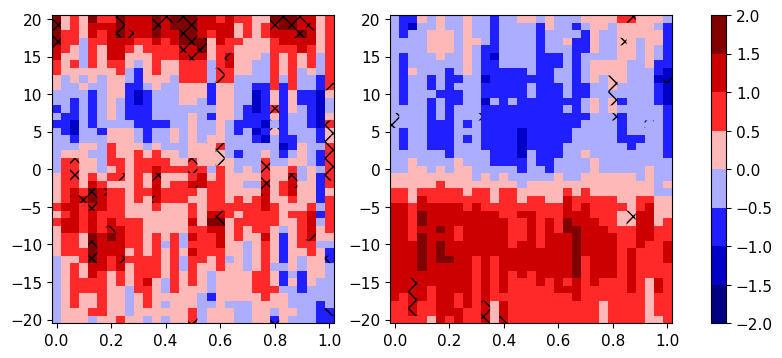

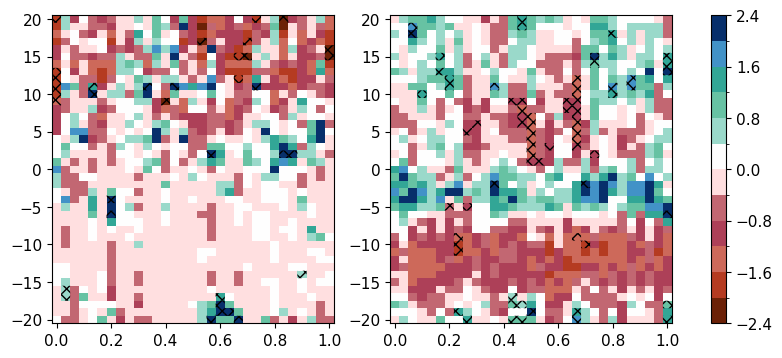

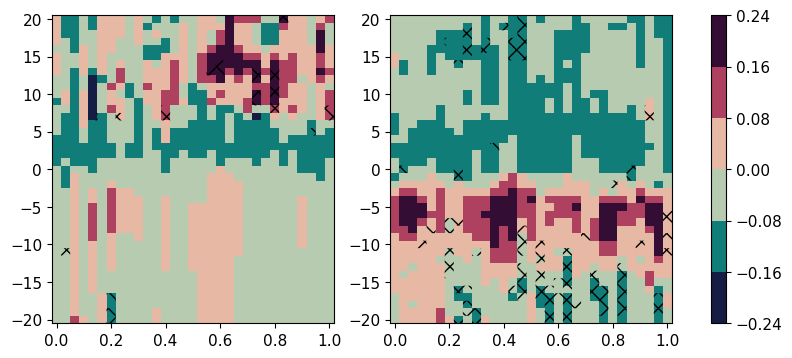

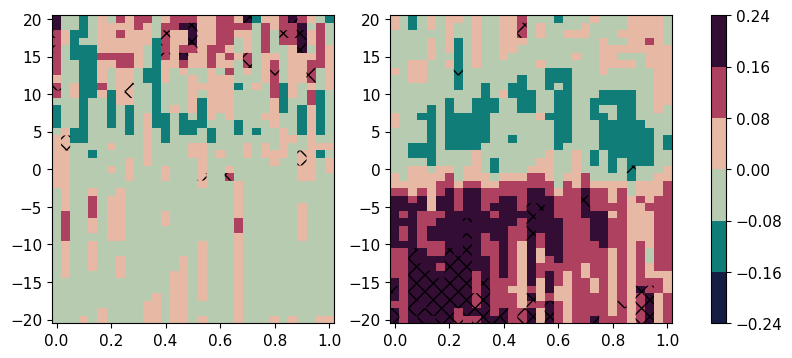

In [95]:
spells_som = spells.filter(pl.col("value") == 8)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

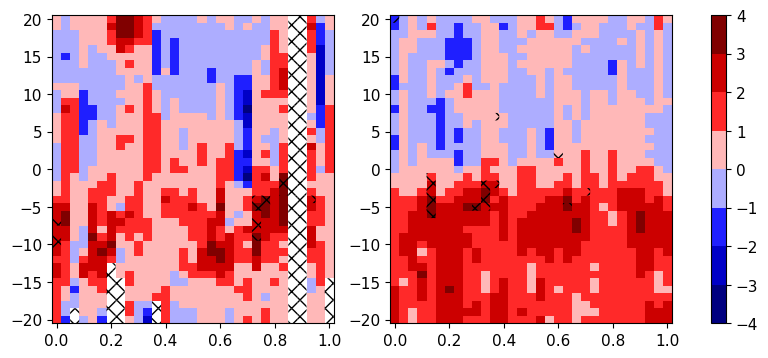

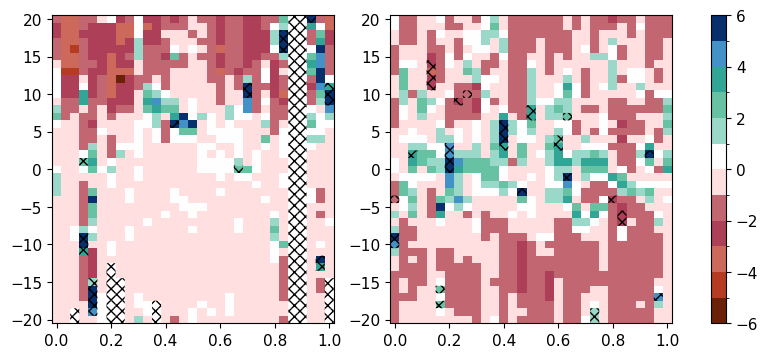

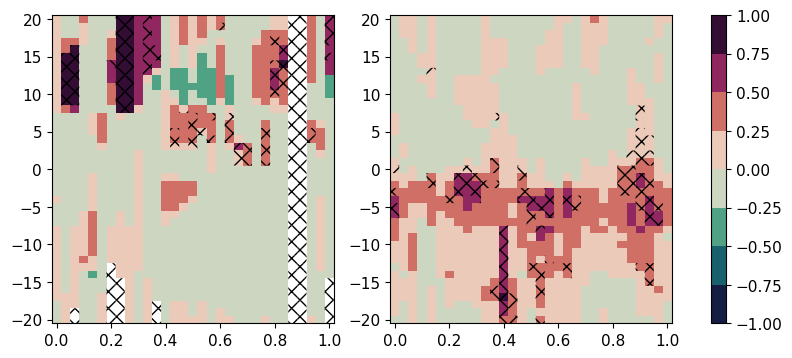

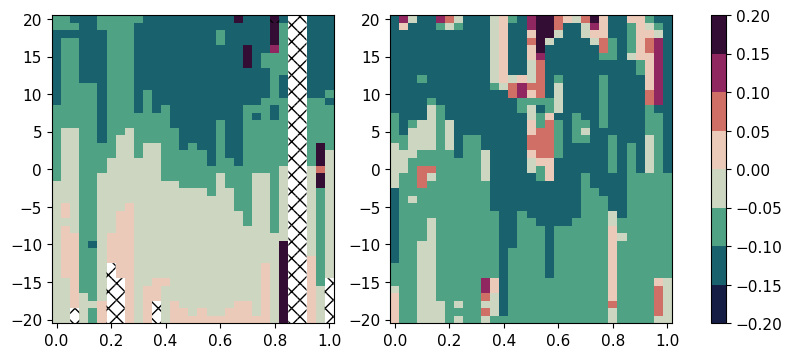

In [96]:
spells_som = spells.filter(pl.col("value") == 9)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

[<Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>,
 <Figure size 1000x400 with 3 Axes>]

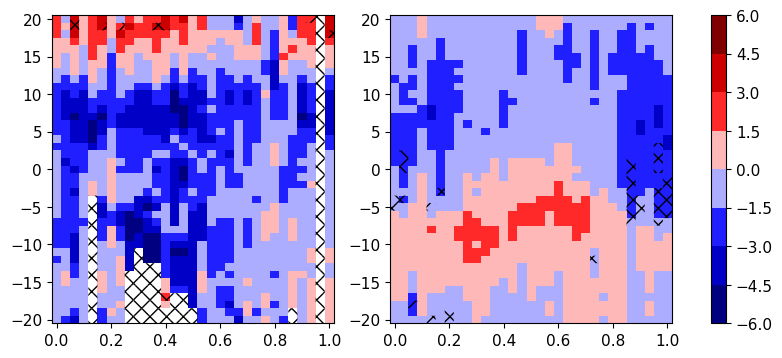

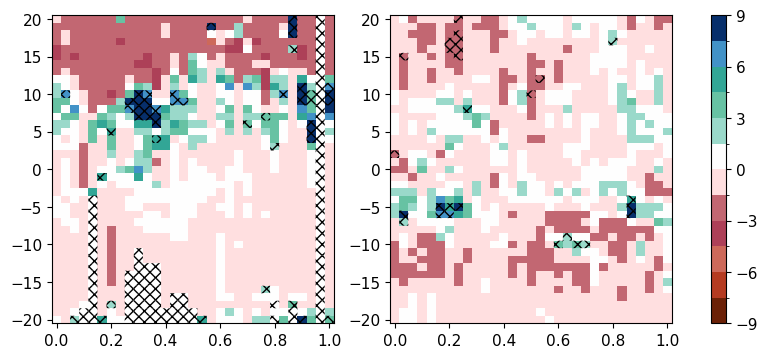

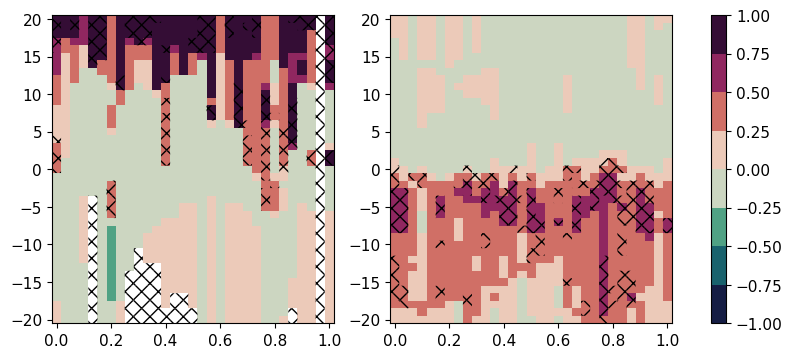

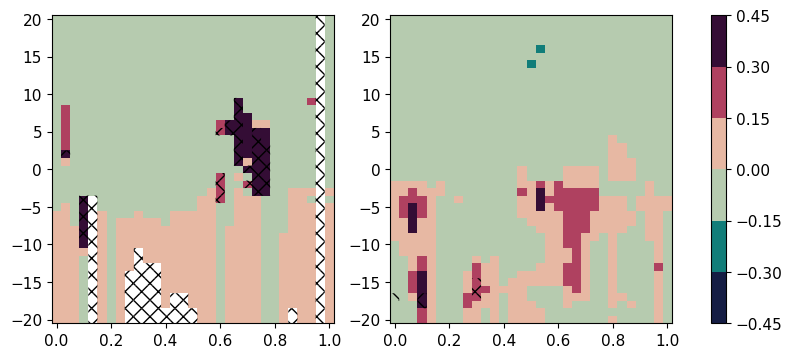

In [97]:
spells_som = spells.filter(pl.col("value") == 10)
spells_som = subset_around_onset(spells_som, around_onset=datetime.timedelta(days=1))

plot_all_relative_composites(jets_daily, spells_som, variable_dict, 50)

# masked jets

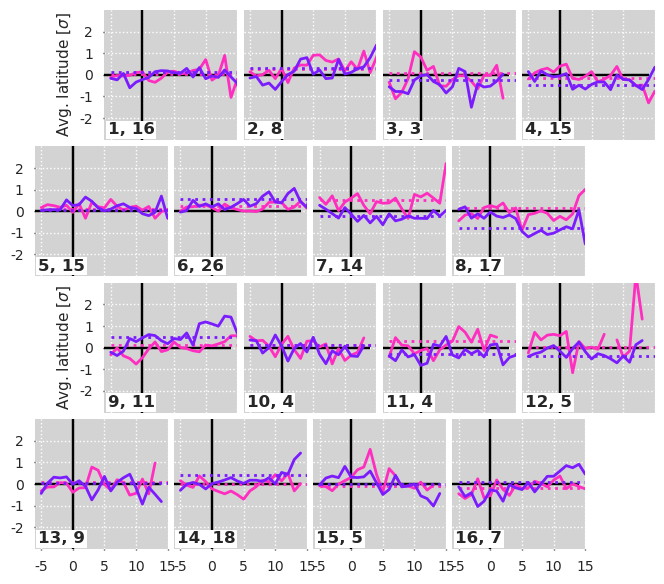

In [37]:
plt.style.use('seaborn-v0_8')
fig, axes = honeycomb_panel(
    4, 4, .4, hspace=0.05, wspace=0.1,
)
fig.set_size_inches(8, 7)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "mean_lat"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j), number in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape)), numbering):
    ax.spines[["top", "bottom"]].set_visible(False)
    ax.vlines(0, -3, 3, color="black")
    ax.hlines(0, -6, 14, color="black")
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 14])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
        if i in [0, 2]:
            ax.set_ylabel(fr"{PRETTIER_VARNAME[varname]} [$\sigma$]")
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
    ax.annotate(
        number,
        (2.2, 4),
        xycoords="axes points",
        ha="left",
        va="baseline",
        fontweight="demi",
        fontsize=12,
        bbox={
            "boxstyle": "square, pad=0.1",
            "edgecolor": "none",
            "facecolor": "white",
        },
        usetex=False,
    )

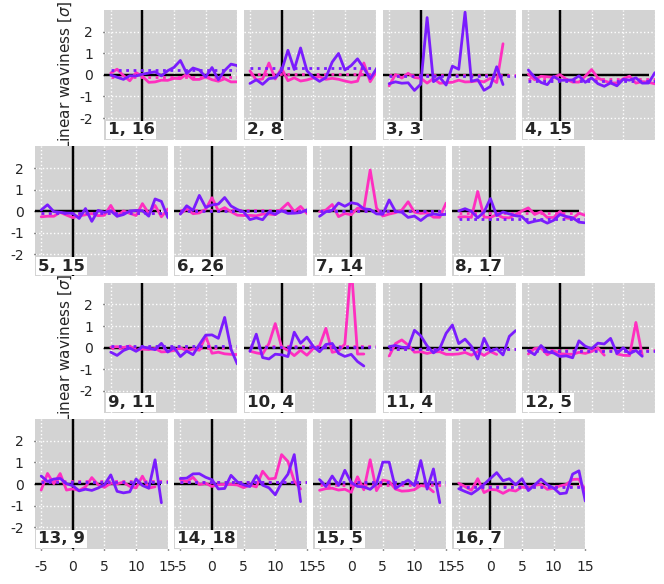

In [38]:
plt.style.use('seaborn-v0_8')
fig, axes = honeycomb_panel(
    4, 4, .4, hspace=0.05, wspace=0.1,
)
fig.set_size_inches(8, 7)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "waviness1"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j), number in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape)), numbering):
    ax.spines[["top", "bottom"]].set_visible(False)
    ax.vlines(0, -3, 3, color="black")
    ax.hlines(0, -6, 14, color="black")
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 14])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
        if i in [0, 2]:
            ax.set_ylabel(fr"{PRETTIER_VARNAME[varname]} [$\sigma$]")
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
    ax.annotate(
        number,
        (2.2, 4),
        xycoords="axes points",
        ha="left",
        va="baseline",
        fontweight="demi",
        fontsize=12,
        bbox={
            "boxstyle": "square, pad=0.1",
            "edgecolor": "none",
            "facecolor": "white",
        },
        usetex=False,
    )

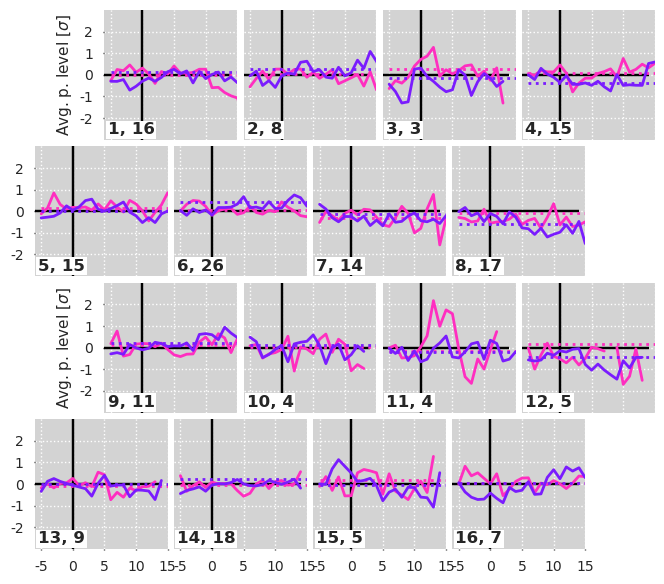

In [39]:
plt.style.use('seaborn-v0_8')
fig, axes = honeycomb_panel(
    4, 4, .4, hspace=0.05, wspace=0.1,
)
fig.set_size_inches(8, 7)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "mean_lev"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j), number in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape)), numbering):
    ax.spines[["top", "bottom"]].set_visible(False)
    ax.vlines(0, -3, 3, color="black")
    ax.hlines(0, -6, 14, color="black")
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 14])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
        if i in [0, 2]:
            ax.set_ylabel(fr"{PRETTIER_VARNAME[varname]} [$\sigma$]")
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
    ax.annotate(
        number,
        (2.2, 4),
        xycoords="axes points",
        ha="left",
        va="baseline",
        fontweight="demi",
        fontsize=12,
        bbox={
            "boxstyle": "square, pad=0.1",
            "edgecolor": "none",
            "facecolor": "white",
        },
        usetex=False,
    )

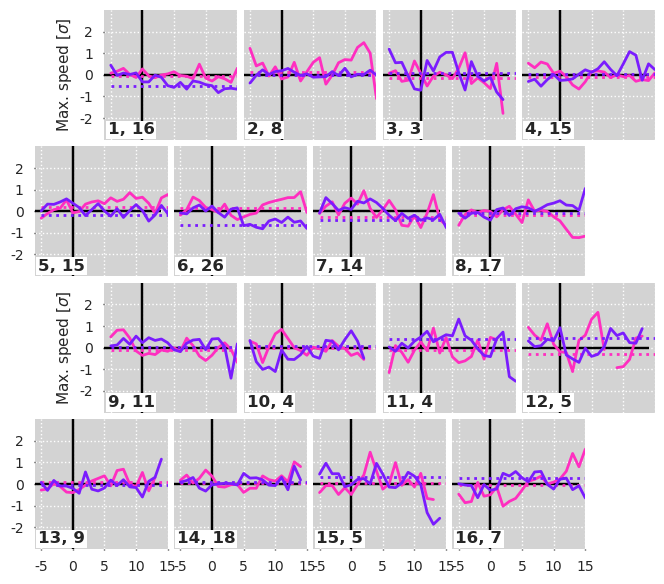

In [40]:
plt.style.use('seaborn-v0_8')
fig, axes = honeycomb_panel(
    4, 4, .4, hspace=0.05, wspace=0.1,
)
fig.set_size_inches(8, 7)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "s_star"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j), number in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape)), numbering):
    ax.spines[["top", "bottom"]].set_visible(False)
    ax.vlines(0, -3, 3, color="black")
    ax.hlines(0, -6, 14, color="black")
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 14])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
        if i in [0, 2]:
            ax.set_ylabel(fr"{PRETTIER_VARNAME[varname]} [$\sigma$]")
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
    ax.annotate(
        number,
        (2.2, 4),
        xycoords="axes points",
        ha="left",
        va="baseline",
        fontweight="demi",
        fontsize=12,
        bbox={
            "boxstyle": "square, pad=0.1",
            "edgecolor": "none",
            "facecolor": "white",
        },
        usetex=False,
    )

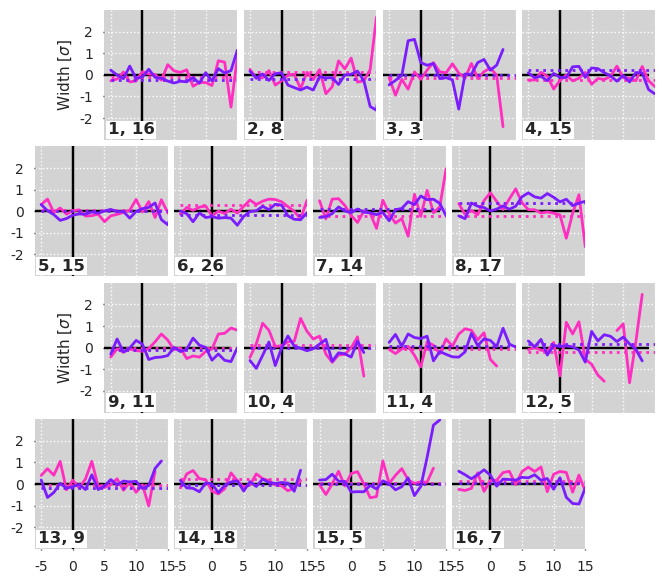

In [41]:
plt.style.use('seaborn-v0_8')
fig, axes = honeycomb_panel(
    4, 4, .4, hspace=0.05, wspace=0.1,
)
fig.set_size_inches(8, 7)
rel_ind_ticks = [-5, 0, 5, 10, 15]
anom_ticks = [-2, -1, 0, 1, 2]
varname = "width"
mean_anoms = {}
for jet in ["STJ", "EDJ"]:
    to_plot = props_as_df_anoms.filter(pl.col("time").cast(pl.Datetime("us")).is_in(labels["time"].values.astype('datetime64[ms]').tolist()), pl.col("jet") == jet)[varname].to_numpy()
    mean_anoms[jet] = timeseries_on_map(to_plot, net.latest_bmus)[0]
for (l, ax), (i, j), number in zip(enumerate(axes.ravel()), zip(*np.unravel_index(np.arange(axes.size), axes.shape)), numbering):
    ax.spines[["top", "bottom"]].set_visible(False)
    ax.vlines(0, -3, 3, color="black")
    ax.hlines(0, -6, 14, color="black")
    for k, jet in enumerate(["STJ", "EDJ"]):
        to_plot_ = props_masked_.filter(pl.col("jet") == jet, pl.col("cluster") == l)
        ax.plot(to_plot_["relative_index"], to_plot_[varname], color=COLORS[2 - k], lw=2)
        ax.plot([rel_ind_ticks[0], rel_ind_ticks[-1]], [mean_anoms[jet][l], mean_anoms[jet][l]], color=COLORS[2 - k], lw=2, linestyle="dotted")
    ax.grid(linestyle="dotted")
    ax.set_xlim([-6, 14])
    ax.set_ylim([-3, 3])
    ax.set_facecolor('lightgray')
    if i == 3:
        ax.set_xticks(rel_ind_ticks, labels=rel_ind_ticks)
        ax.tick_params(axis='x', width=1, size=1)
    else:
        ax.set_xticks(rel_ind_ticks, labels=[])
        ax.tick_params(axis='x', width=0, size=0)
    if j == 0:
        ax.set_yticks(anom_ticks, labels=anom_ticks)
        ax.tick_params(axis='y', width=1, size=1)
        if i in [0, 2]:
            ax.set_ylabel(fr"{PRETTIER_VARNAME[varname]} [$\sigma$]")
    else:       
        ax.set_yticks(anom_ticks, labels=[])
        ax.tick_params(axis='y', width=0, size=0)
    ax.annotate(
        number,
        (2.2, 4),
        xycoords="axes points",
        ha="left",
        va="baseline",
        fontweight="demi",
        fontsize=12,
        bbox={
            "boxstyle": "square, pad=0.1",
            "edgecolor": "none",
            "facecolor": "white",
        },
        usetex=False,
    )

In [26]:
ds_summer = ds.sel(time=summer_daily.to_numpy())
ds_summer = compute(ds_summer, progress_flag=True)

In [ ]:
uvs_masked = mask_from_spells_pl(spells, ds_summer)

In [22]:
uvs_masked_per_cluster = uvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = uvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
uvs_masked_per_cluster = uvs_masked_per_cluster.sel(cluster=indexer)
uvs_masked_per_cluster = uvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))
uvs_masked_per_cluster.loc[{"cluster": to_zero}] = 0.

In [23]:
uvs_masked_per_cluster

<xarray.Dataset> Size: 255MB
Dimensions:         (cluster: 16, relative_index: 21, lat: 131, lon: 241)
Coordinates:
    relative_time   (relative_index) timedelta64[ns] 168B 0 days ... 20 days
  * relative_index  (relative_index) int32 84B 0 1 2 3 4 5 ... 15 16 17 18 19 20
  * lat             (lat) float32 524B 15.0 15.5 16.0 16.5 ... 79.0 79.5 80.0
  * lon             (lon) float32 964B -80.0 -79.5 -79.0 ... 39.0 39.5 40.0
  * cluster         (cluster) int64 128B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    s               (cluster, relative_index, lat, lon) float32 42MB 13.4 ......
    lev             (cluster, relative_index, lat, lon) float32 42MB 180.0 .....
    u               (cluster, relative_index, lat, lon) float32 42MB 8.603 .....
    v               (cluster, relative_index, lat, lon) float32 42MB 0.4816 ....
    theta           (cluster, relative_index, lat, lon) float64 85MB 349.2 .....

In [24]:
uvs_masked_per_cluster.reset_coords("relative_time")

<xarray.Dataset> Size: 255MB
Dimensions:         (cluster: 16, relative_index: 21, lat: 131, lon: 241)
Coordinates:
  * relative_index  (relative_index) int32 84B 0 1 2 3 4 5 ... 15 16 17 18 19 20
  * lat             (lat) float32 524B 15.0 15.5 16.0 16.5 ... 79.0 79.5 80.0
  * lon             (lon) float32 964B -80.0 -79.5 -79.0 ... 39.0 39.5 40.0
  * cluster         (cluster) int64 128B 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
Data variables:
    s               (cluster, relative_index, lat, lon) float32 42MB 13.4 ......
    lev             (cluster, relative_index, lat, lon) float32 42MB 180.0 .....
    u               (cluster, relative_index, lat, lon) float32 42MB 8.603 .....
    v               (cluster, relative_index, lat, lon) float32 42MB 0.4816 ....
    theta           (cluster, relative_index, lat, lon) float64 85MB 349.2 .....
    relative_time   (relative_index) timedelta64[ns] 168B 0 days ... 20 days

In [25]:
jets_masked = find_all_jets(uvs_masked_per_cluster.reset_coords("relative_time"), base_s_thresh=0.75)

100%|██████████| 336/336 [00:00<00:00, 374.94it/s]


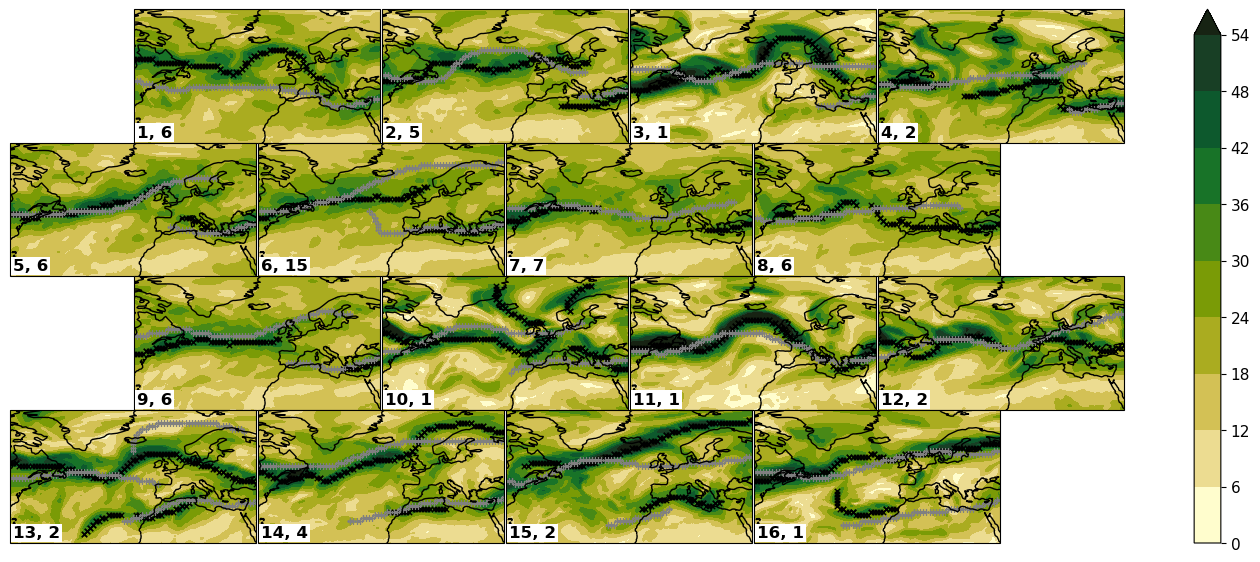

In [88]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(uvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(uvs_masked_per_cluster["s"].sel(relative_index=0), cmap=colormaps.speed, levels=9, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker="x")
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, color="gray", lw=1, s=15, marker="+")

# Real space composites

## temp

In [26]:
da_T = compute(da_T, progress_flag=True)

100%|██████████| 16/16 [00:00<00:00, 332.40it/s]


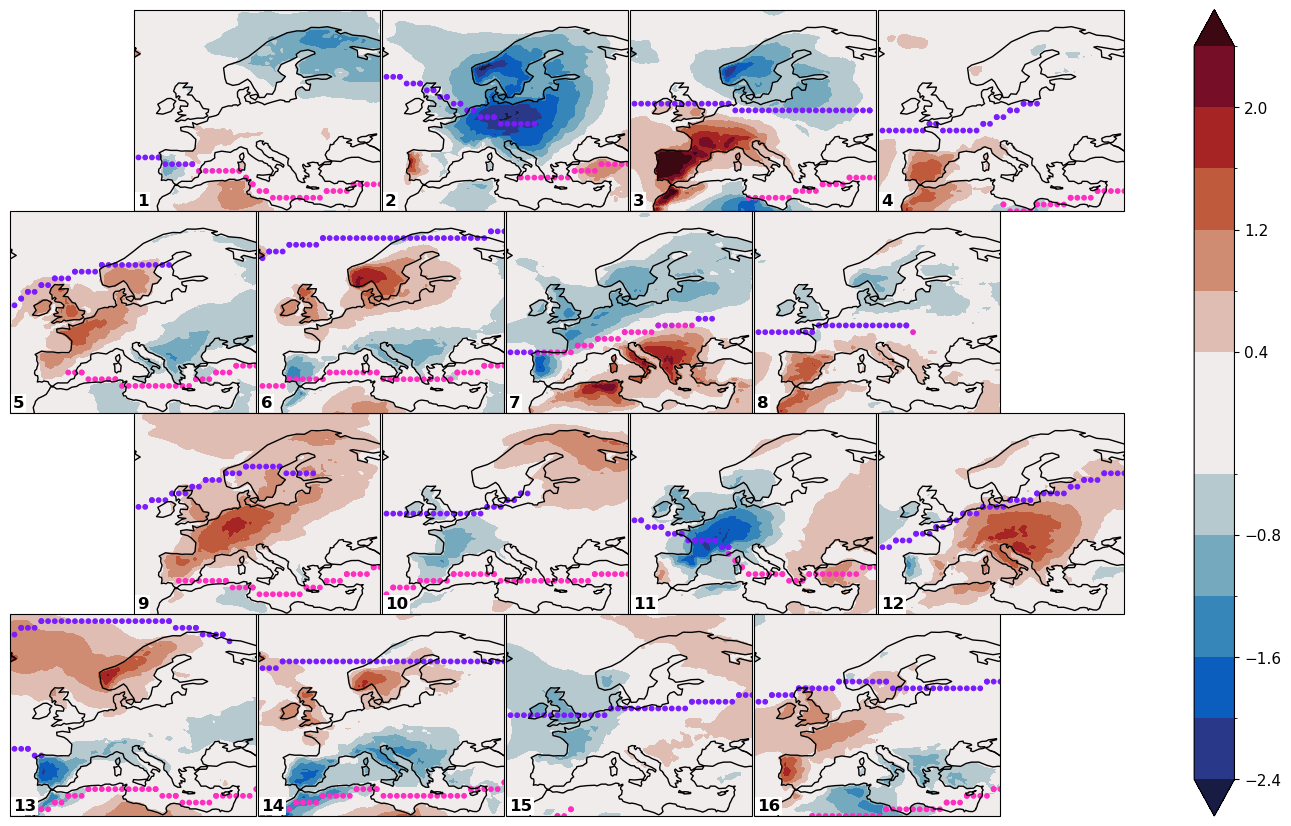

In [27]:
da_T_europe = extract(da_T, "all", None, -15, 40, 30, 75)
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_T_europe), numbering=True)
_ = clu.add_any_contour_from_mask(da_T_europe, mask_daily, cmap=colormaps.balance, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [41]:
import regionmask
T_masked = mask_from_spells_pl(spells, da_T)
prudence = regionmask.defined_regions.prudence.mask_3D(da_T.lon, da_T.lat)

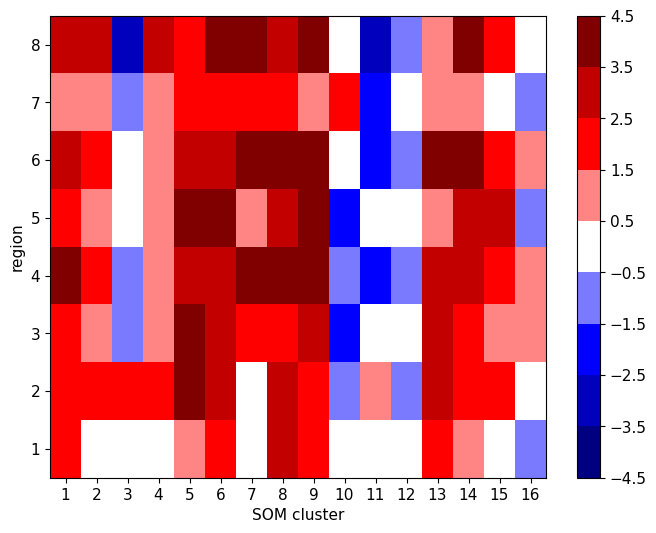

In [76]:
mask_around_onset = (T_masked.relative_index < 4) & (T_masked.relative_index >= 0)
fig, ax = plt.subplots(figsize=(8, 6))
ouais = []
for r in prudence.region:
    to_plot = T_masked.where(prudence.sel(region=r) & mask_around_onset)
    to_plot = to_plot.mean(["lon", "lat", "relative_index"]).groupby("value").max().values
    ouais.append(to_plot)
    # ax.plot(to_plot, label=r.item())
cmap = colormaps.BlWhRe
im = ax.pcolormesh(np.stack(ouais), cmap=cmap, norm=BoundaryNorm(np.arange(-4.5, 5), cmap.N))
ax.set_xticks(np.arange(16) + 0.5, labels=np.arange(1, 17))
ax.set_xlabel("SOM cluster")
ax.set_yticks(np.arange(8) + 0.5, labels=np.arange(1, 9))
ax.set_ylabel("region")
fig.colorbar(im, ax=ax)

<GeoAxes: >

Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip


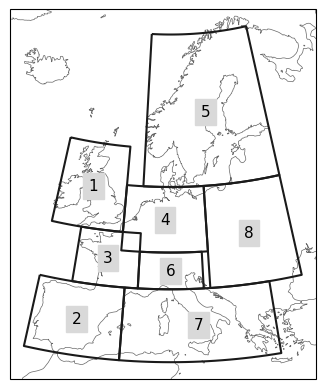

In [45]:
proj = ccrs.LambertConformal(central_longitude=10)
regionmask.defined_regions.prudence.plot(projection=proj, resolution="50m")

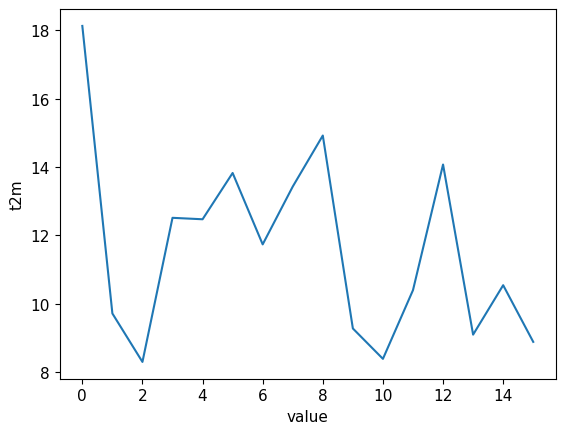

In [30]:
T_masked.where((T_masked.relative_index < 4) & (T_masked.relative_index >= 0)).max(["lon", "lat", "relative_index"]).groupby("value").max().plot()

In [72]:
T_masked_per_cluster = T_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = T_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
T_masked_per_cluster = T_masked_per_cluster.sel(cluster=indexer)
T_masked_per_cluster[to_zero, ...] = 0.
T_masked_per_cluster = T_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

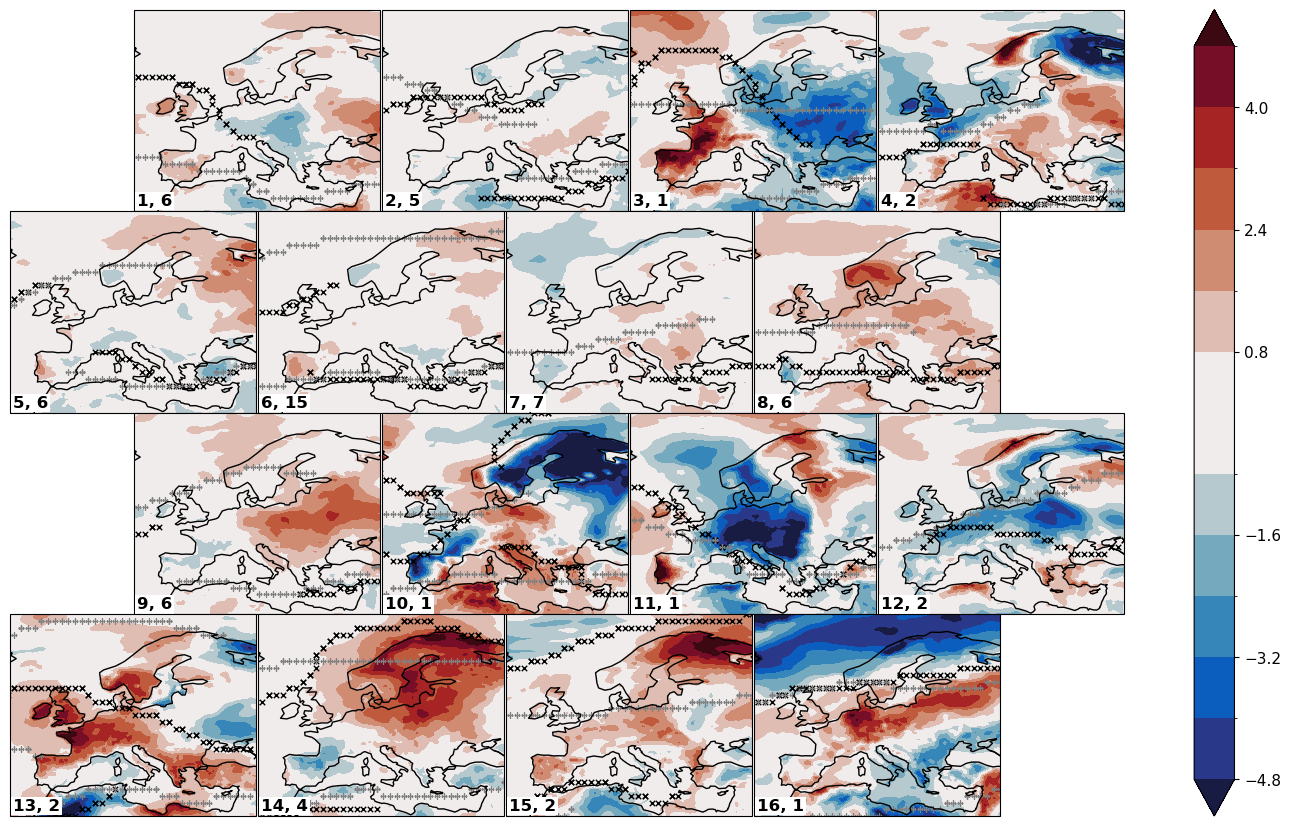

In [73]:
T_masked_per_cluster_europe = extract(T_masked_per_cluster, "all", None, -15, 40, 30, 75)

clu = Clusterplot(4, 4, honeycomb=True, region=get_region(T_masked_per_cluster_europe), numbering=numbering)
_ = clu.add_contourf(T_masked_per_cluster_europe.sel(relative_index=0), cmap=colormaps.balance, levels=13, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker="x")
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, color="gray", lw=1, s=15, marker="+")

## precip

In [ ]:
da_tp = compute(da_tp, progress_flag=True)

 75%|███████▌  | 12/16 [00:00<00:00, 52.05it/s]

100%|██████████| 16/16 [00:00<00:00, 54.44it/s]


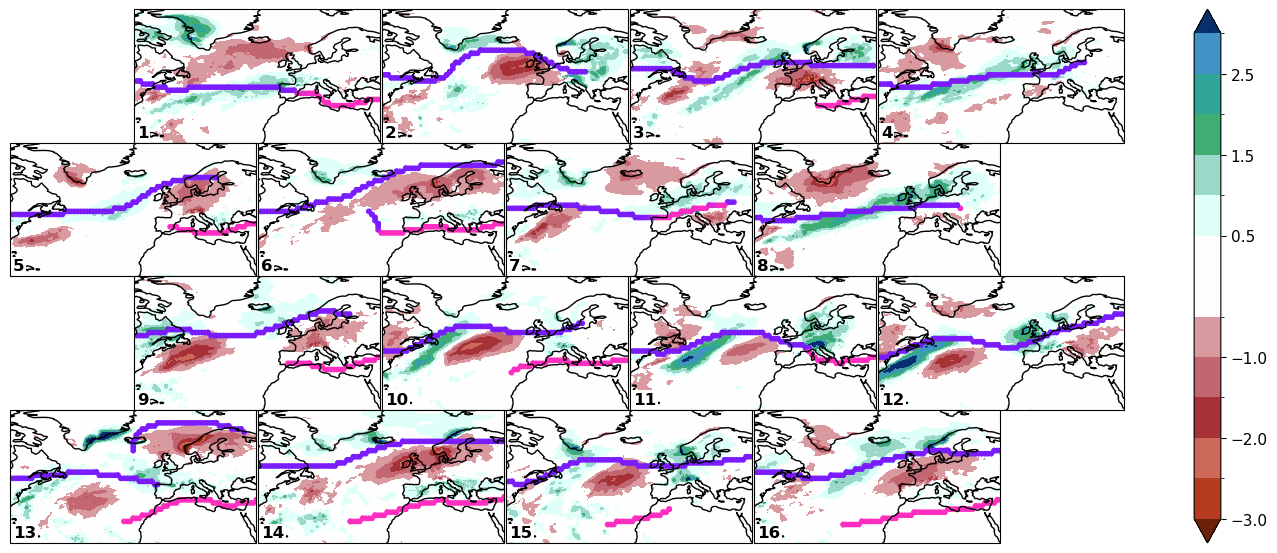

In [ ]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_tp), numbering=True)
_ = clu.add_any_contour_from_mask(da_tp * 1000, mask_daily, cmap=colormaps.precip4_diff_19lev, levels=12, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [ ]:
tp_masked = mask_from_spells_pl(spells, da_tp)

In [ ]:
tp_masked_per_cluster = tp_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = tp_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
tp_masked_per_cluster = tp_masked_per_cluster.sel(cluster=indexer)
tp_masked_per_cluster[to_zero, ...] = 0.
tp_masked_per_cluster = tp_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

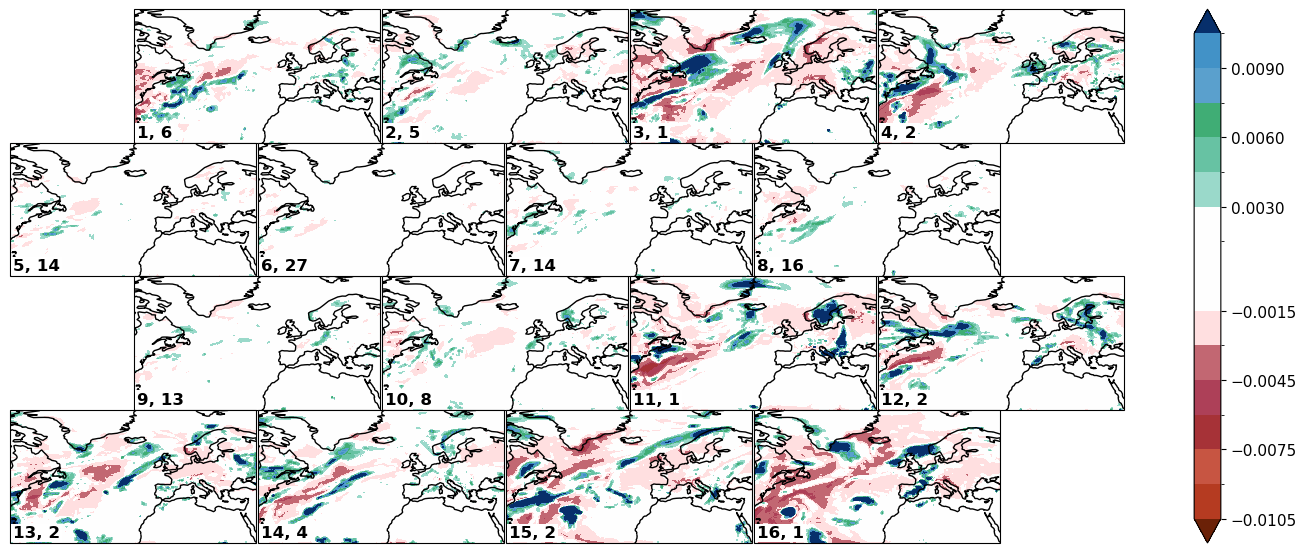

In [ ]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(tp_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=0), cmap=colormaps.precip4_diff_19lev, levels=13, q=1-1e-2)

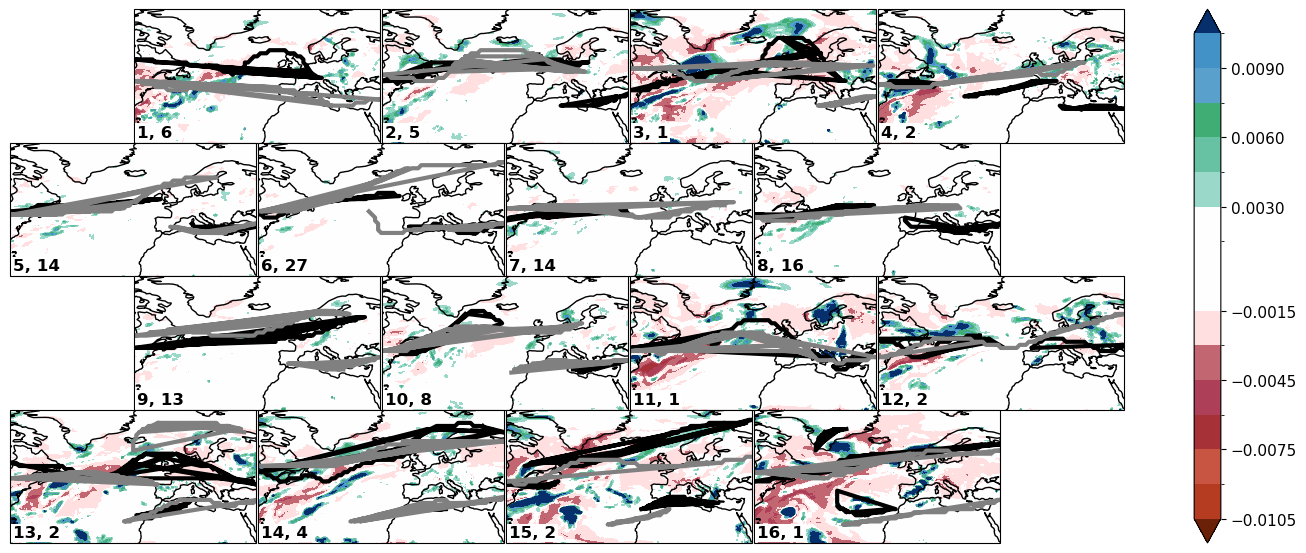

In [ ]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(tp_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(tp_masked_per_cluster.sel(relative_index=0), cmap=colormaps.precip4_diff_19lev, levels=13, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker="x")
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, color="gray", lw=1, s=15, marker="+")

## aPVS

In [ ]:
da_apvs = compute(da_apvs, progress_flag=True)

 38%|███▊      | 6/16 [00:00<00:00, 54.60it/s]

100%|██████████| 16/16 [00:00<00:00, 54.41it/s]


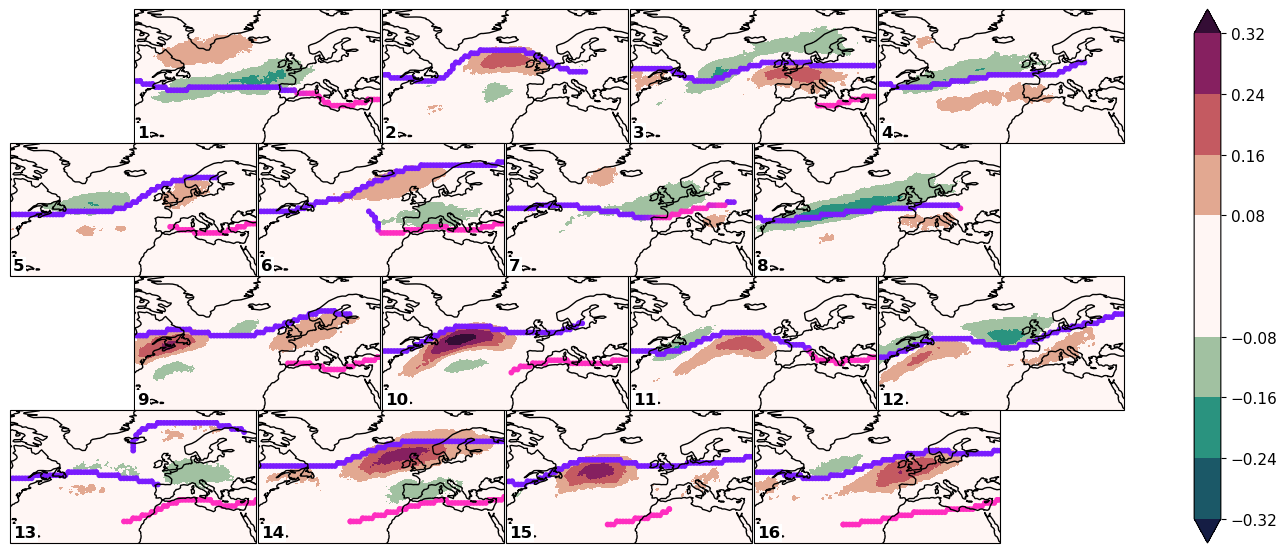

In [ ]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_apvs), numbering=True)
_ = clu.add_any_contour_from_mask(da_apvs, mask_daily, cmap=colormaps.curl, levels=7, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [ ]:
apvs_masked = mask_from_spells_pl(spells, da_apvs)

In [ ]:
apvs_masked_per_cluster = apvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = apvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
apvs_masked_per_cluster = apvs_masked_per_cluster.sel(cluster=indexer)
apvs_masked_per_cluster[to_zero, ...] = 0.
apvs_masked_per_cluster = apvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

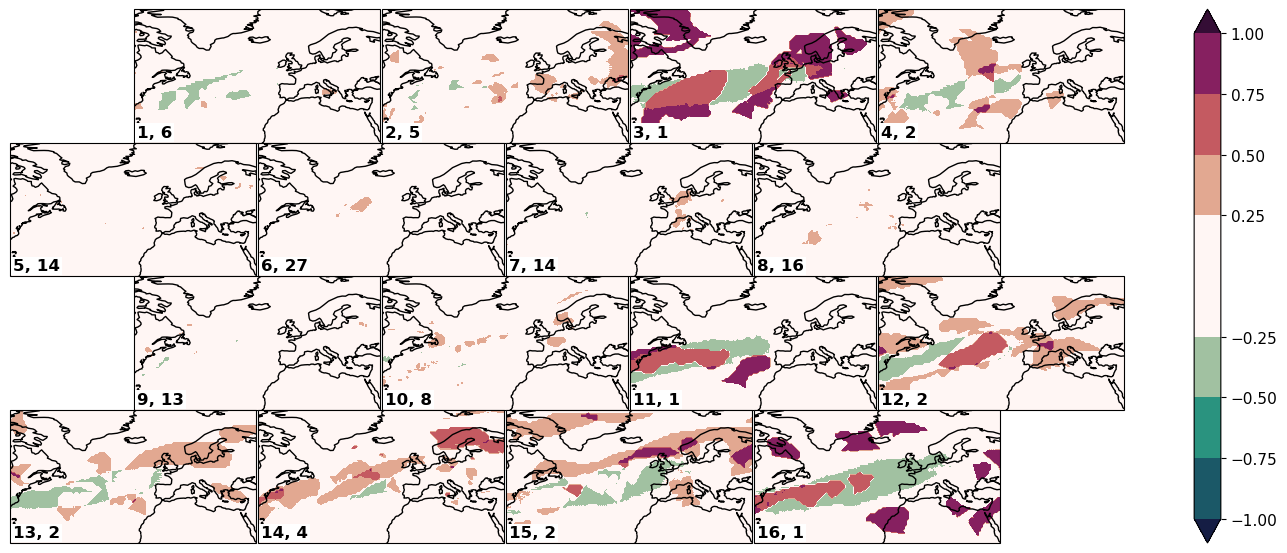

In [ ]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(apvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(apvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.curl, levels=7, q=1-1e-2)

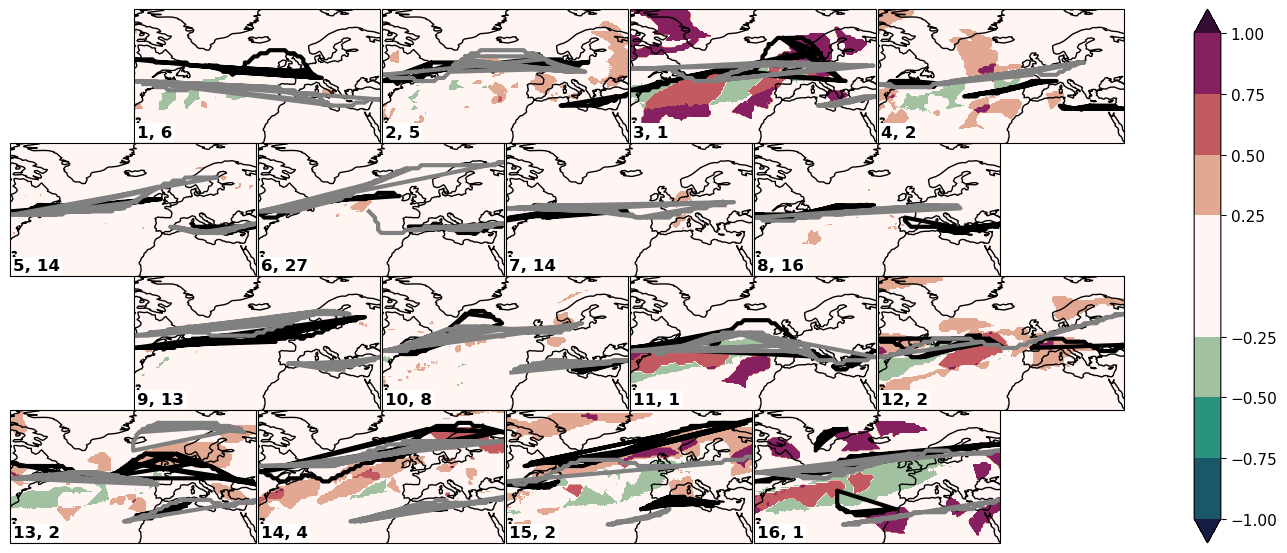

In [ ]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(apvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(apvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.curl, levels=7, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker="x")
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, color="gray", lw=1, s=15, marker="+")

## cPVS

In [ ]:
da_cpvs = compute(da_cpvs, progress_flag=True)

  0%|          | 0/16 [00:00<?, ?it/s]

100%|██████████| 16/16 [00:00<00:00, 54.37it/s]


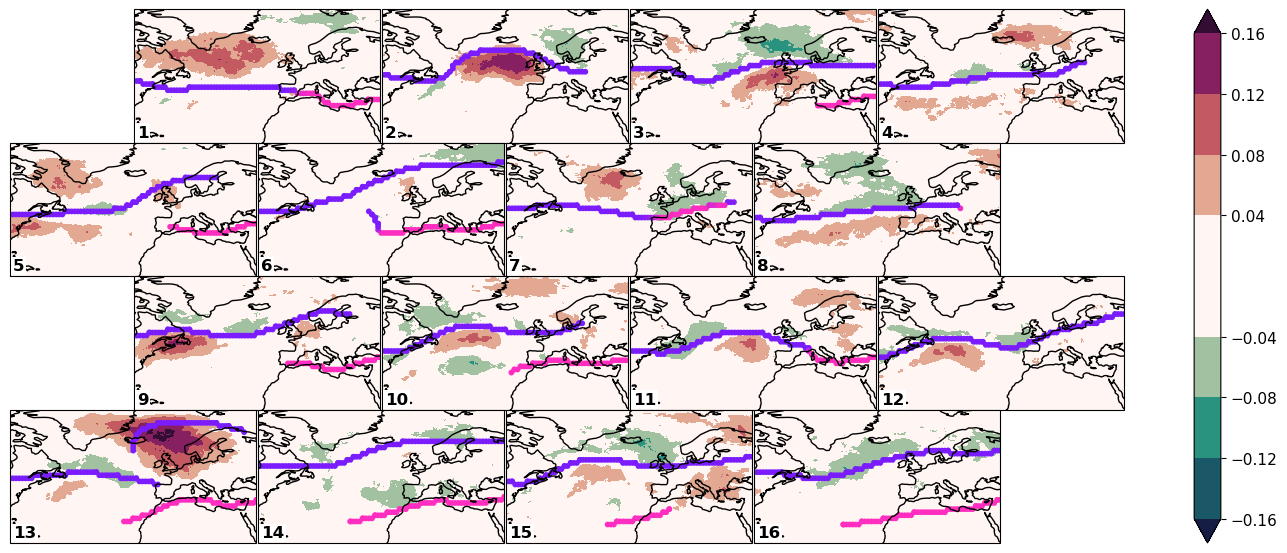

In [ ]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(da_cpvs), numbering=True)
_ = clu.add_any_contour_from_mask(da_cpvs, mask_daily, cmap=colormaps.curl, levels=9, q=1-1e-3)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, c=is_p, lw=1, s=10, cmap=PINKPURPLE, vmin=0, vmax=1)

In [ ]:
cpvs_masked = mask_from_spells_pl(spells, da_cpvs)

In [ ]:
cpvs_masked_per_cluster = cpvs_masked.groupby("value").mean("spell").rename({"value": "cluster"})
u_clu = cpvs_masked_per_cluster.cluster.values.astype(np.int32)
to_zero = np.arange(net.n_nodes)[~np.isin(np.arange(net.n_nodes), u_clu)]
indexer = np.repeat(u_clu, np.diff(np.append(u_clu, [net.n_nodes])))
cpvs_masked_per_cluster = cpvs_masked_per_cluster.sel(cluster=indexer)
cpvs_masked_per_cluster[to_zero, ...] = 0.
cpvs_masked_per_cluster = cpvs_masked_per_cluster.assign_coords(cluster=np.arange(net.n_nodes))

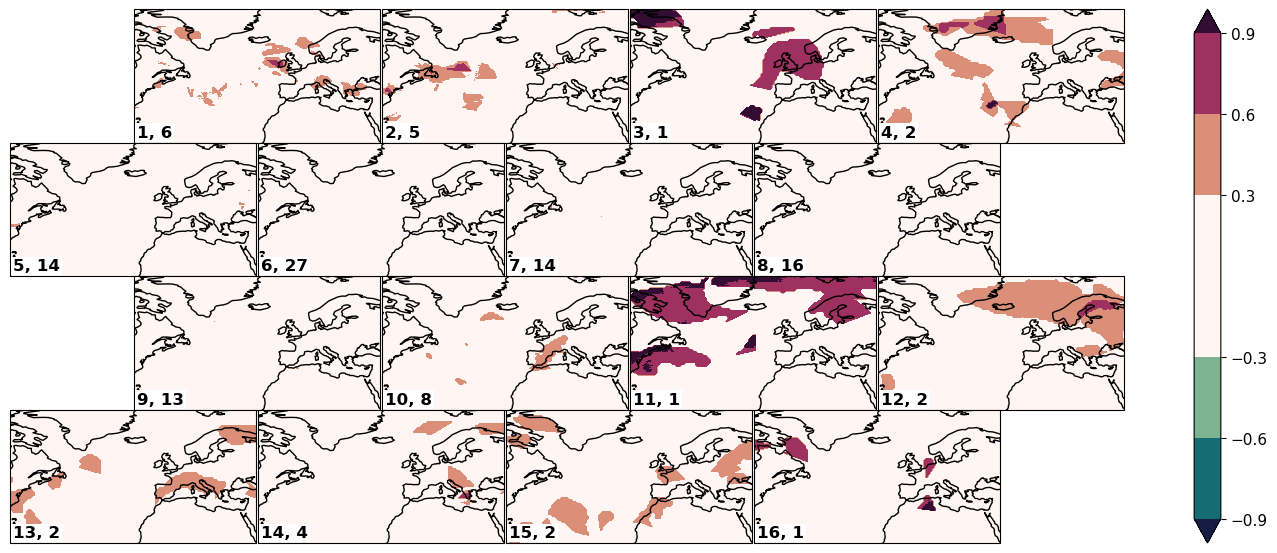

In [ ]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(cpvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(cpvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.curl, levels=7, q=1-1e-2)

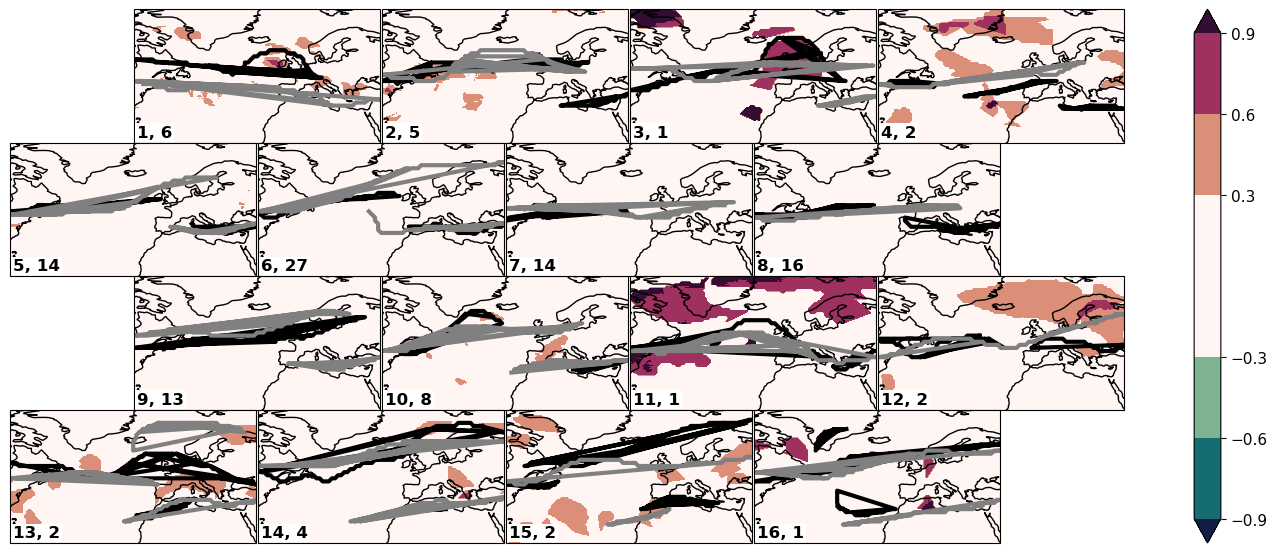

In [ ]:
clu = Clusterplot(4, 4, honeycomb=True, region=get_region(cpvs_masked_per_cluster), numbering=numbering)
_ = clu.add_contourf(cpvs_masked_per_cluster.sel(relative_index=0), cmap=colormaps.curl, levels=7, q=1-1e-2)
axes = clu.axes.ravel()
for i in range(net.n_nodes):
    jets = jets_masked.filter(pl.col("cluster") == i, pl.col("relative_index") == 0)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la = jet[["lon", "lat"]].to_numpy().T
        axes[i].scatter(lo, la, lw=1, s=15, c="black", marker="x")
for i in range(net.n_nodes):
    jets = all_jets_center_summer.filter(pl.col("cluster") == i)
    for j, jet in jets.group_by("jet ID", maintain_order=True):
        lo, la, is_p = jet[["lon", "lat", "is_polar"]].to_numpy().T
        axes[i].scatter(lo, la, color="gray", lw=1, s=15, marker="+")